In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import DatasetFolder

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc
from sklearn.preprocessing import label_binarize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
# !unzip '/content/drive/MyDrive/Colab Notebooks/Warm-ups/dataset.zip' -d '/content/drive/MyDrive/Colab Notebooks/Warm-ups'

In [3]:
# Define the transformations
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.to(torch.float32)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

root = '../dataset'

# Initialize DatasetFolder for train and validation datasets
train_dataset = DatasetFolder(
    root=os.path.join(root, 'train'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)
test_dataset = DatasetFolder(
    root=os.path.join(root, 'val'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)

In [4]:
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.9), int(len(train_dataset) * 0.1)])

In [5]:
batch_size = 60
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Classes: {train_dataset.dataset.classes}')
print(f'Image tensor type: {train_dataset[0][0].dtype}')
print(f'Batches: {len(train_loader)}')

Train dataset size: 27000
Val dataset size: 3000
Test dataset size: 7500
Image shape: torch.Size([1, 150, 150])
Classes: ['no', 'sphere', 'vort']
Image tensor type: torch.float32
Batches: 450


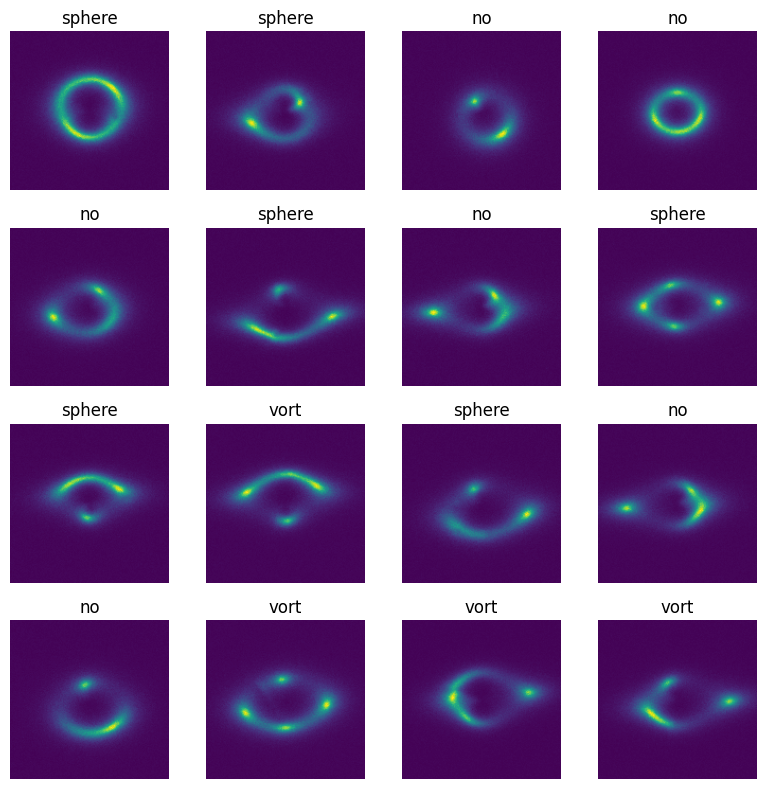

In [7]:
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# Visualize some images in the train dataset
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    if i < 16:
        image, label = images[i], labels[i]

        img = image.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(train_dataset.dataset.classes[label])
        ax.axis('off')
    else:
        break

plt.tight_layout()
plt.show()

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_corrects += torch.sum(preds == labels.data).item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_corrects / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data).item()

            val_loss /= len(val_loader.dataset)
            val_acc = val_corrects / len(val_loader.dataset)

        # Step the scheduler
        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), '../best_param_resnet18_1.pt')

        print(f'Epoch [{epoch + 1}/{num_epochs}]:')
        print(f'\tTrain Loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}')
        print(f'\tVal Loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}')

        model.load_state_dict(torch.load('../best_param_resnet18_1.pt'))

    return model

In [9]:
def evaluate_model(model, criterion, name):
    model.eval()
    y_pred_probs = []
    y_true = []
    total_loss = 0.0
    total_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            total_corrects += torch.sum(preds == labels).item()

            y_pred_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    test_loss = total_loss / len(test_loader.dataset)
    test_acc = total_corrects / len(test_loader.dataset)

    # Binarize the labels for ROC AUC
    y_true_binary = label_binarize(y_true, classes=[0, 1, 2])

    # Compute ROC AUC
    roc_auc = roc_auc_score(y_true_binary, y_pred_probs, multi_class='ovr')

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {test_acc:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    classes = ['no', 'sphere', 'vort']

    # Plot confusion matrix
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, np.argmax(y_pred_probs, axis=1))
    sns.heatmap(cm, annot=True, fmt='d', cmap='icefire', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Plot ROC curve for each class
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(np.array(y_true_binary).ravel(), np.array(y_pred_probs).ravel())
    plt.plot(fpr, tpr, color='orange', label=f'{name}, {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

In [10]:
model = models.resnet18(weights=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = torch.nn.Linear(model.fc.in_features, 3)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)
criterion = nn.CrossEntropyLoss()

model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)
print('Finished')

Epoch [1/20]:
	Train Loss: 0.9981	Train Acc: 0.4526
	Val Loss: 1.0368	Val Acc: 0.5637
Epoch [2/20]:
	Train Loss: 0.4750	Train Acc: 0.8098
	Val Loss: 0.5291	Val Acc: 0.8033
Epoch [3/20]:
	Train Loss: 0.3190	Train Acc: 0.8807
	Val Loss: 0.3412	Val Acc: 0.8743
Epoch [4/20]:
	Train Loss: 0.2654	Train Acc: 0.9020
	Val Loss: 0.2920	Val Acc: 0.8960
Epoch [5/20]:
	Train Loss: 0.2292	Train Acc: 0.9164
	Val Loss: 0.2209	Val Acc: 0.9157
Epoch [6/20]:
	Train Loss: 0.2022	Train Acc: 0.9271
	Val Loss: 0.2361	Val Acc: 0.9210
Epoch [7/20]:
	Train Loss: 0.1822	Train Acc: 0.9342
	Val Loss: 0.2211	Val Acc: 0.9230
Epoch [8/20]:
	Train Loss: 0.1621	Train Acc: 0.9411
	Val Loss: 0.2050	Val Acc: 0.9300
Epoch [9/20]:
	Train Loss: 0.1412	Train Acc: 0.9488
	Val Loss: 0.3246	Val Acc: 0.9087
Epoch [10/20]:
	Train Loss: 0.1494	Train Acc: 0.9447
	Val Loss: 0.2391	Val Acc: 0.9190
Epoch [11/20]:
	Train Loss: 0.1413	Train Acc: 0.9489
	Val Loss: 0.2128	Val Acc: 0.9240
Epoch [12/20]:
	Train Loss: 0.1464	Train Acc: 0.9478

In [12]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Warm-ups/best_param.pt'))
model.load_state_dict(torch.load('../best_param_resnet18.pt'))

RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for conv1.weight: copying a param with shape torch.Size([64, 3, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 1, 7, 7]).

Test Loss: 1.0983
Accuracy: 0.3463
ROC AUC: 0.5182


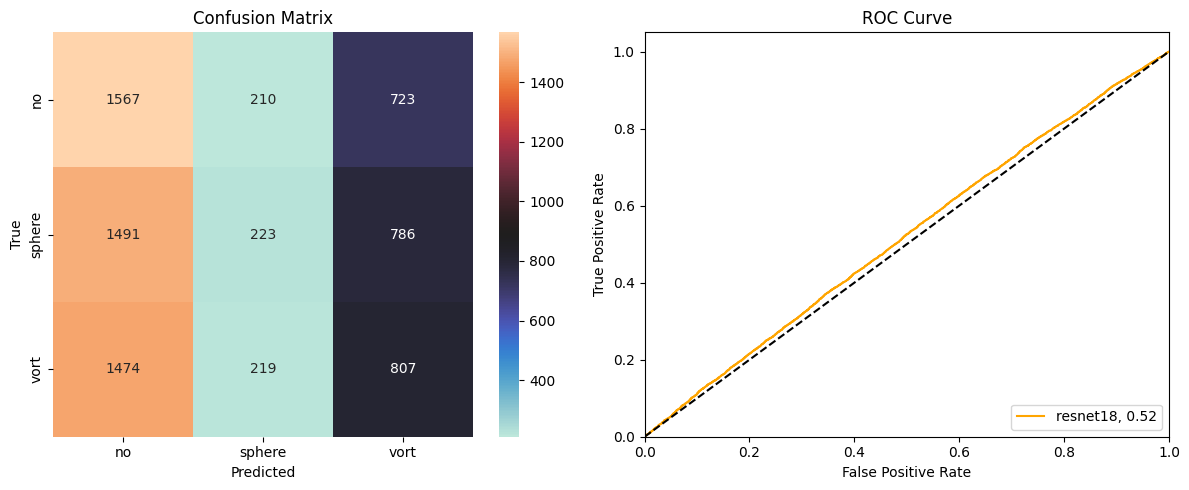

In [12]:
evaluate_model(model, criterion, 'resnet18')